# Отчет по лабораторной работе 7.1

## Измерение углового распределения жесткой компоненты космического излучения
Конкс Эрик, Б01-818

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy import odr

In [2]:
I = [834, 679, 724, 549]
I = [I_i - 532 for I_i in I]
I_err = [1 for _ in range(len(I))]
θ = [0, 20, 45, 65]
θ_err = [5 for _ in range(len(θ))]
lnI = [np.log(i) for i in I]
lnI_err = [I_err[i] / I[i] for i in range(len(I))]
cosθ = [np.cos(np.radians(θ_i)) for θ_i in θ]
ln_cosθ = [np.log(cosθ_i) for cosθ_i in cosθ]
cosθ_err = [np.sin(np.radians(θ[i])) * np.radians(θ_err[i]) for i in range(len(θ))]
ln_cosθ_err = [cosθ_err[i] / cosθ[i] for i in range(len(cosθ))]
ln_cosθ_err[0] = ln_cosθ_err[1]
df = pd.DataFrame({'I': I, 'ΔI': I_err, 'lnI': lnI, 'ΔlnI': lnI_err,
                   'θ': θ, 'Δθ': θ_err, 'ln(cosθ)': ln_cosθ, 'Δln(cosθ)': ln_cosθ_err})
x = ln_cosθ
x_err = ln_cosθ_err
y = lnI
y_err = lnI_err
print(df)
print(y, y_err)

     I  ΔI       lnI      ΔlnI   θ  Δθ  ln(cosθ)  Δln(cosθ)
0  302   1  5.710427  0.003311   0   5  0.000000   0.031762
1  147   1  4.990433  0.006803  20   5 -0.062202   0.031762
2  192   1  5.257495  0.005208  45   5 -0.346574   0.087266
3   17   1  2.833213  0.058824  65   5 -0.861286   0.187144
[5.71042701737487, 4.990432586778736, 5.2574953720277815, 2.833213344056216] [0.0033112582781456954, 0.006802721088435374, 0.005208333333333333, 0.058823529411764705]


In [3]:
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [18, 14]

$$I(\theta)=I_0cos^n(\theta)$$

In [4]:
f = lambda p, x: p[0] * x + p[1]
quad_model = odr.Model(f)
data = odr.RealData(x, y, sx=x_err)#, sy=y_err)
modr = odr.ODR(data, quad_model, beta0=[1.6, 1])
out = modr.run()
beta_opt = out.beta
#beta_err = np.sqrt(np.diag(out.cov_beta))
beta_err = out.sd_beta
beta_name = ['a', 'b']
print('Fit parameter 1-sigma error y = a * x + b')
print('—————————————————————————————————————————')
for i in range(len(beta_opt)):
    print(f"{beta_name[i]} = {beta_opt[i]} +- {beta_err[i]}")
    print("    {:.2f} +- {:.2f}".format(beta_opt[i], beta_err[i]))
    
print('chisq = {:.2f}'.format(out.res_var * (len(x) - len(beta_opt))))

Fit parameter 1-sigma error y = a * x + b
—————————————————————————————————————————
a = 2.9752444729355387 +- 0.903856723404612
    2.98 +- 0.90
b = 5.648320487247143 +- 0.3943176327242838
    5.65 +- 0.39
chisq = 0.66


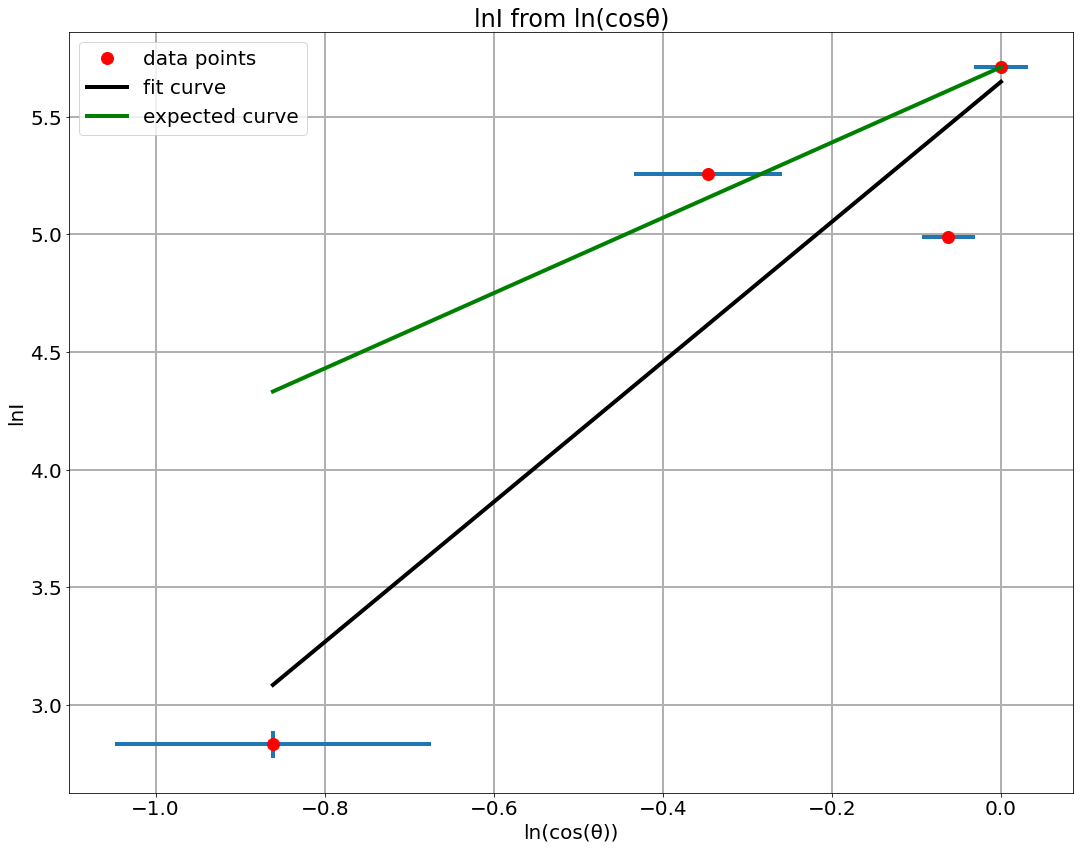

In [11]:
plot = plt.figure(num='lnI from cos(θ)')
plt.plot(x, y, 'ro', label='data points', markersize=12)
x_lin = np.linspace(x[-1], x[0], 1000)
plt.plot(x_lin, [f(beta_opt, x) for x in x_lin], color='black', linewidth=4, label='fit curve')
#print(x_lin)
plt.plot(x, [1.6*x_i + np.log(302) for x_i in x], color='green', linewidth=4, label='expected curve')
plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt="none", linewidth=4)
plt.grid(linewidth=2)
plt.legend()
plt.title('lnI from ln(cosθ)')
plt.xlabel('ln(cos(θ))')
plt.ylabel('lnI')
plt.show()